In [1]:
#Copyright 2021 Google LLC
#
#Licensed under the Apache License, Version 2.0 (the "License");
#you may not use this file except in compliance with the License.
#You may obtain a copy of the License at
#
#    https://www.apache.org/licenses/LICENSE-2.0
#
#Unless required by applicable law or agreed to in writing, software
#distributed under the License is distributed on an "AS IS" BASIS,
#WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#See the License for the specific language governing permissions and 
#limitations under the License.

In [37]:
import warnings
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.datasets as dsets
import torchvision.transforms as transforms
import numpy as np
import random
import copy
import time
import matplotlib.pyplot as plt
from torch.optim.optimizer import Optimizer, required
from opacus.privacy_engine import PrivacyEngine
from opacus.utils import stats
from opacus.utils.tensor_utils import calc_sample_norms
from tqdm import tqdm
import pickle 

warnings.filterwarnings('ignore')
#devicestring = "cpu"
devicestring = "cuda:7" if torch.cuda.is_available() else "cpu"
device = torch.device(devicestring)
print("Running on "+devicestring)

Running on cuda:7


In [5]:
def test(model, train_loader, test_loader, device, prnt):
    model.eval()
    criterion = torch.nn.MSELoss(size_average=True)
    
    losses = []

    with torch.no_grad():
        for images, target in train_loader:
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            preds = torch.round(output).cpu().numpy()
            loss = criterion(output, target)
            losses.append(loss.item())
            
    if prnt:
        print(f"\tTrain set:" f"Loss: {np.mean(losses):.6f} ")
    
    returnval = np.mean(losses)
    if prnt:
        losses = []

        with torch.no_grad():
            for images, target in test_loader:
                images = images.to(device)
                target = target.to(device)

                output = model(images)
                preds = torch.round(output).cpu().numpy()
                loss = criterion(output, target)
                losses.append(loss.item())

            print(f"\Test set:" f"Loss: {np.mean(losses):.6f} ")
    return returnval

Running on dimension 500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 

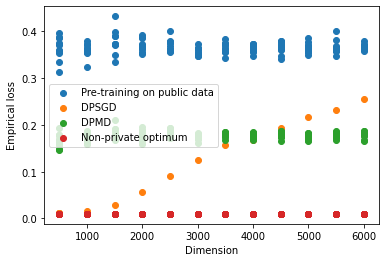

Running on dimension 1000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

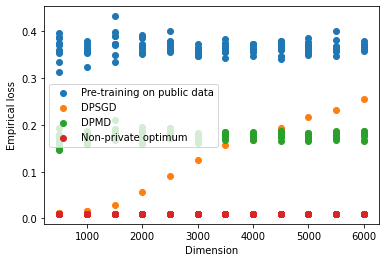

Running on dimension 1500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

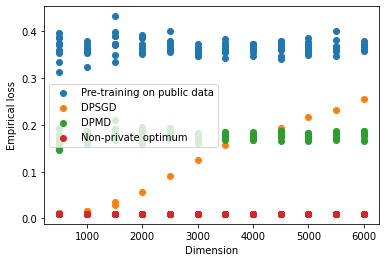

Running on dimension 2000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

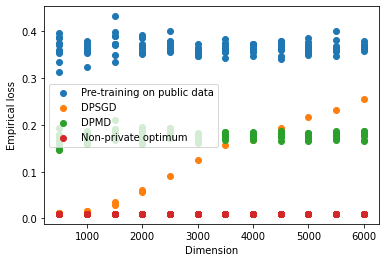

Running on dimension 2500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

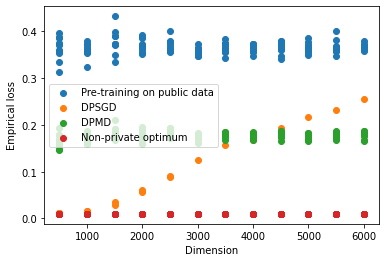

Running on dimension 3000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

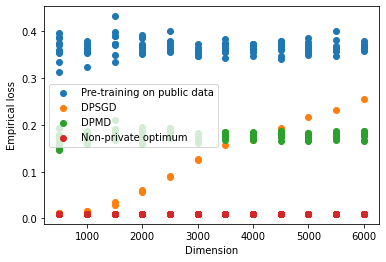

Running on dimension 3500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

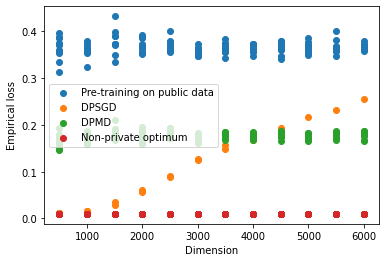

Running on dimension 4000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

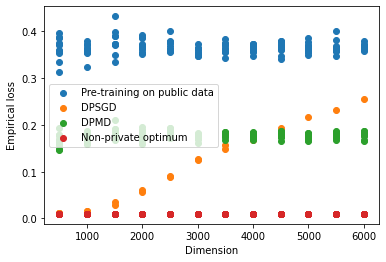

Running on dimension 4500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

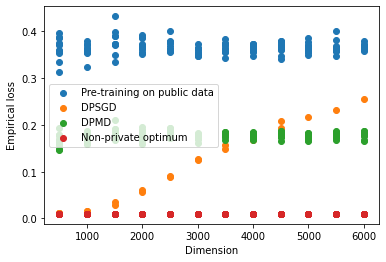

Running on dimension 5000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

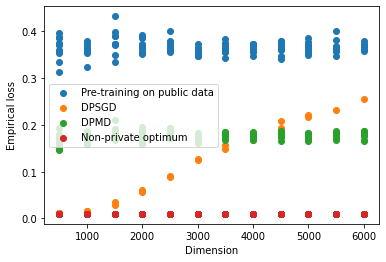

Running on dimension 5500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

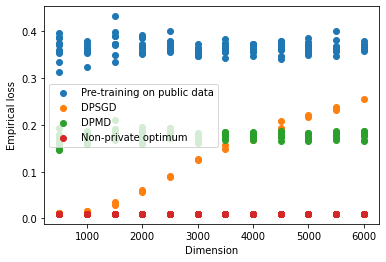

Running on dimension 6000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

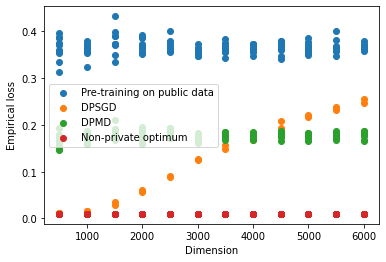

Running on dimension 500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 

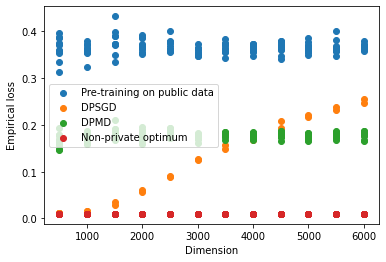

Running on dimension 1000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

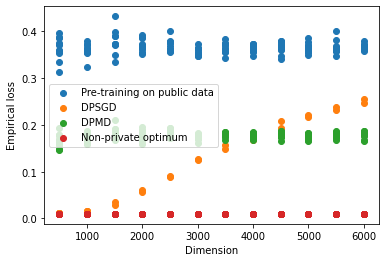

Running on dimension 1500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

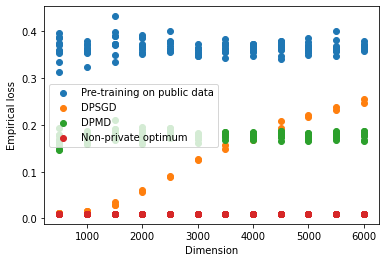

Running on dimension 2000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

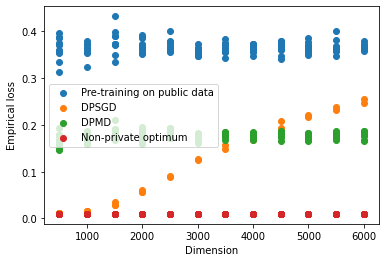

Running on dimension 2500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

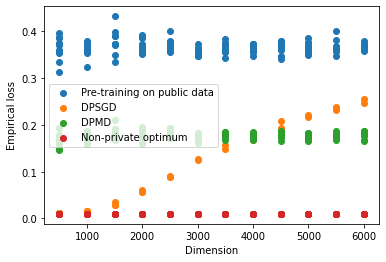

Running on dimension 3000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

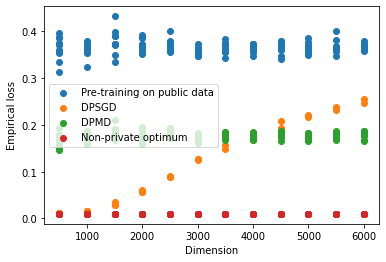

Running on dimension 3500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

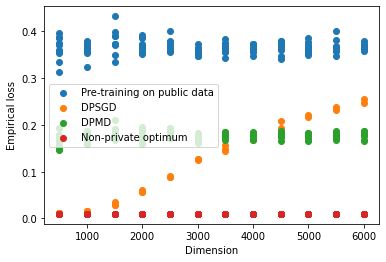

Running on dimension 4000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

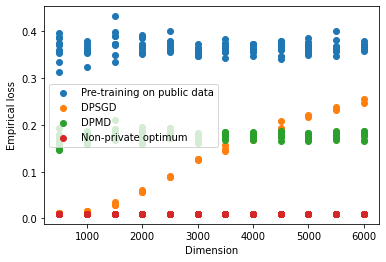

Running on dimension 4500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

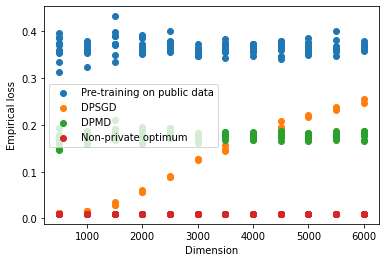

Running on dimension 5000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

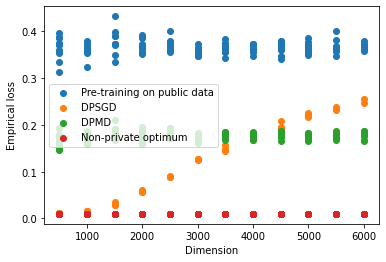

Running on dimension 5500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

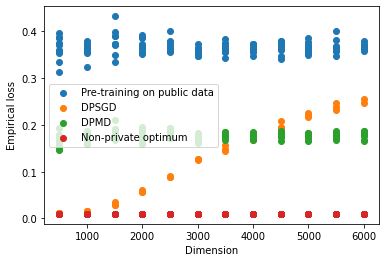

Running on dimension 6000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

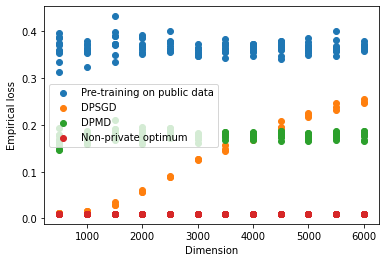

Running on dimension 500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 

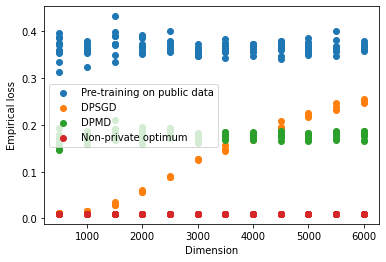

Running on dimension 1000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

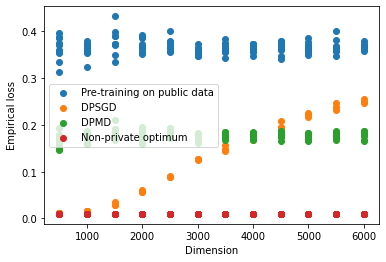

Running on dimension 1500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

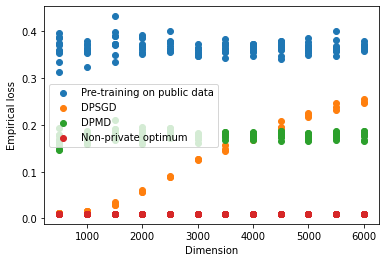

Running on dimension 2000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

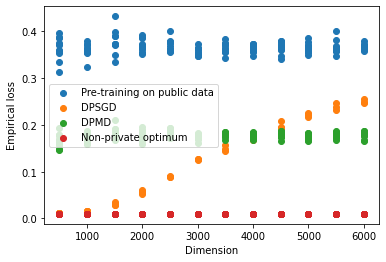

Running on dimension 2500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

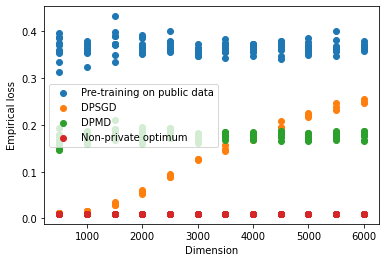

Running on dimension 3000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

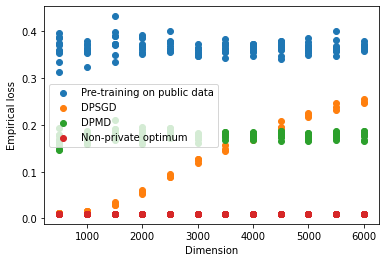

Running on dimension 3500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

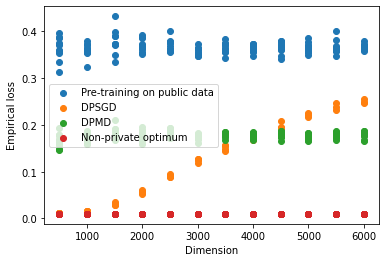

Running on dimension 4000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

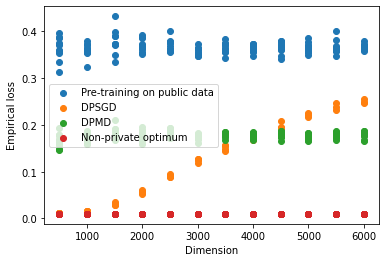

Running on dimension 4500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

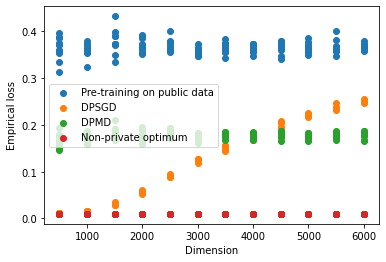

Running on dimension 5000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

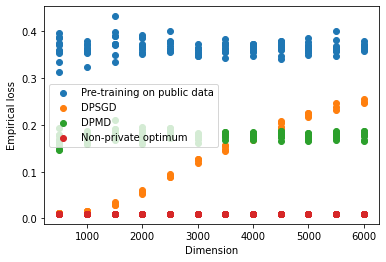

Running on dimension 5500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

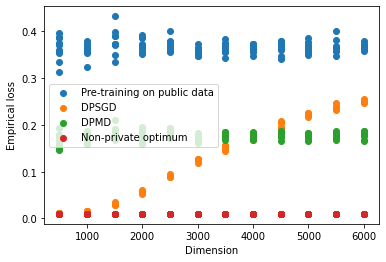

Running on dimension 6000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

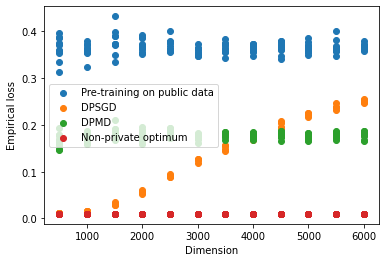

Running on dimension 500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 

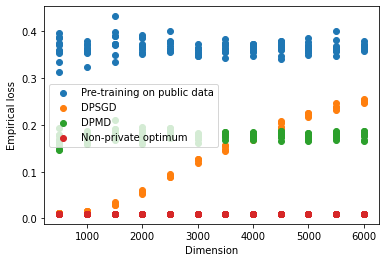

Running on dimension 1000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

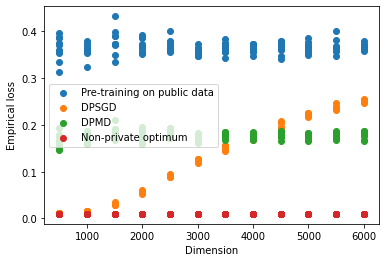

Running on dimension 1500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

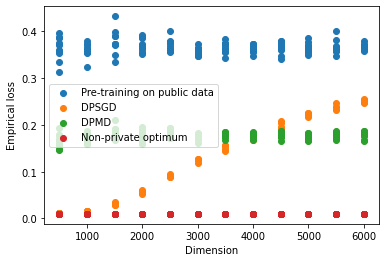

Running on dimension 2000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

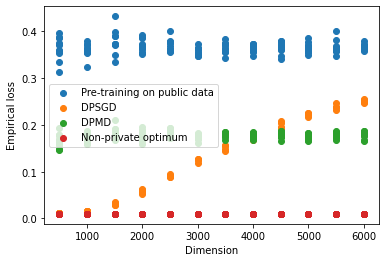

Running on dimension 2500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

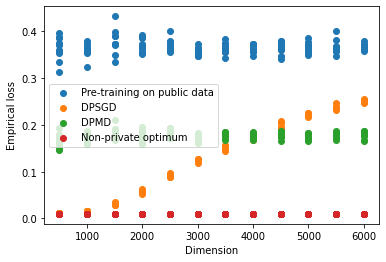

Running on dimension 3000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

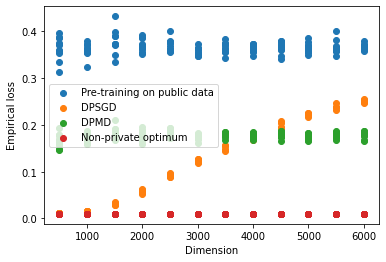

Running on dimension 3500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

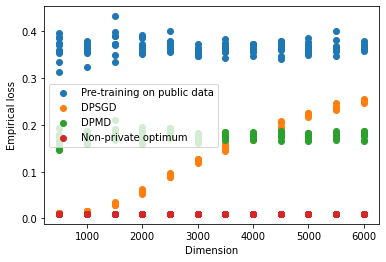

Running on dimension 4000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

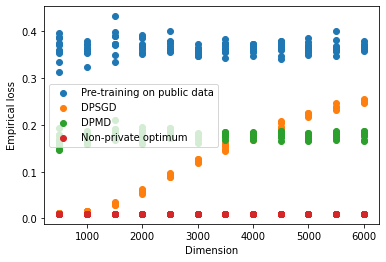

Running on dimension 4500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

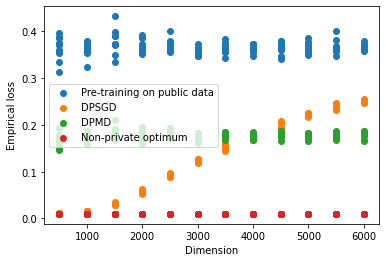

Running on dimension 5000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

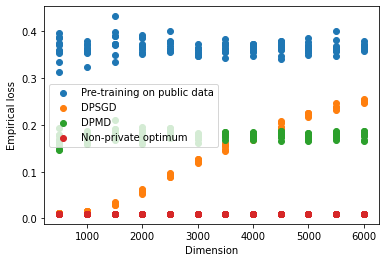

Running on dimension 5500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

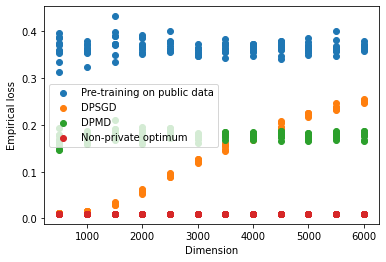

Running on dimension 6000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

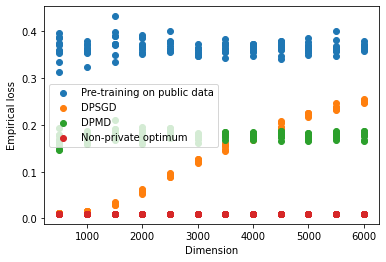

Running on dimension 500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 

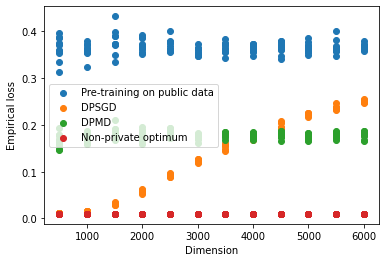

Running on dimension 1000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

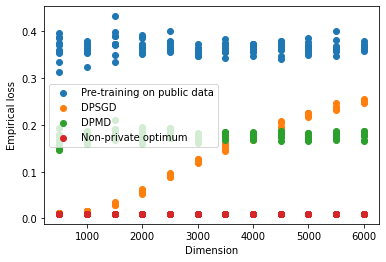

Running on dimension 1500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

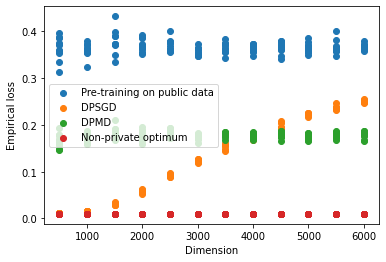

Running on dimension 2000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

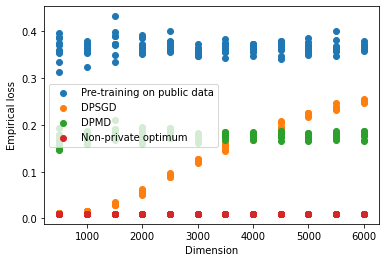

Running on dimension 2500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

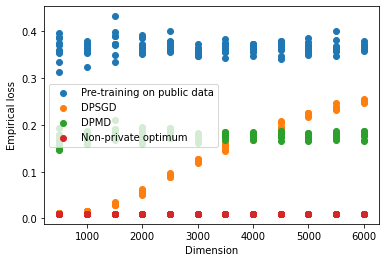

Running on dimension 3000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

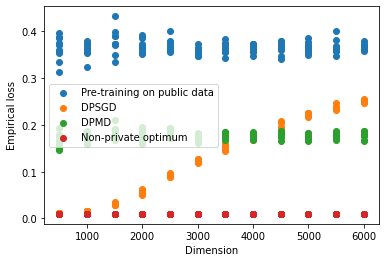

Running on dimension 3500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

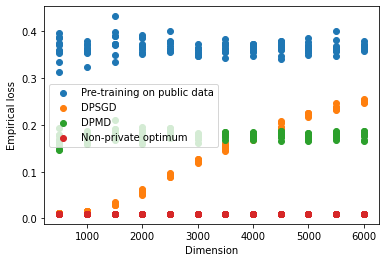

Running on dimension 4000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

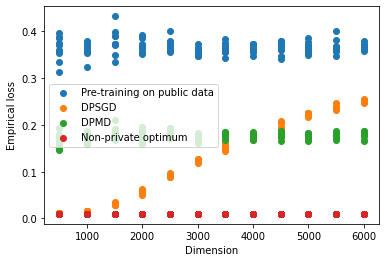

Running on dimension 4500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

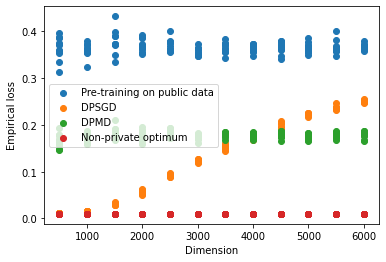

Running on dimension 5000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

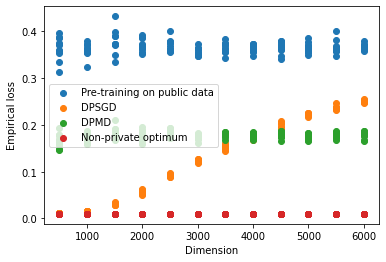

Running on dimension 5500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

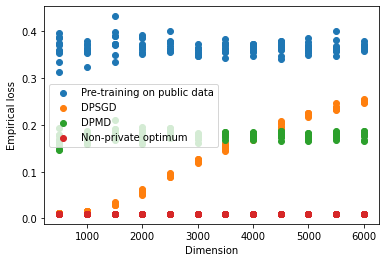

Running on dimension 6000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

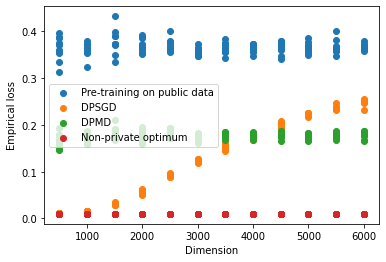

Running on dimension 500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 

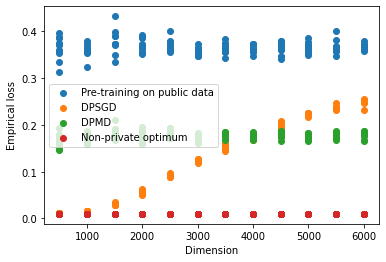

Running on dimension 1000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

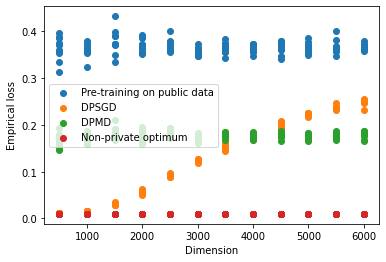

Running on dimension 1500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

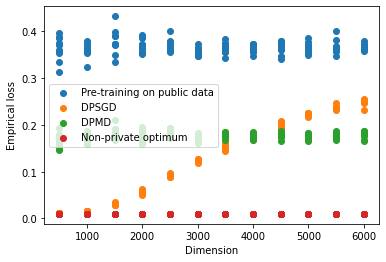

Running on dimension 2000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

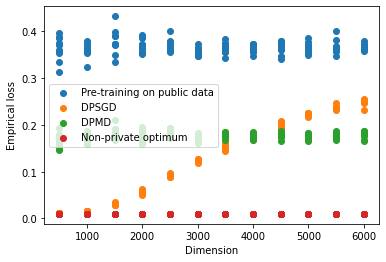

Running on dimension 2500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

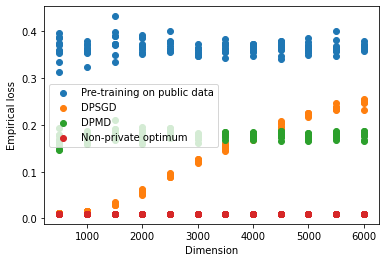

Running on dimension 3000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

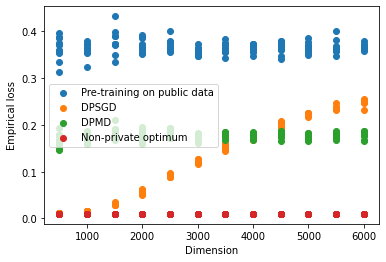

Running on dimension 3500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

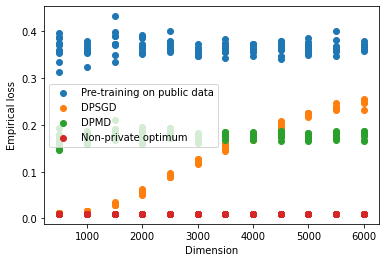

Running on dimension 4000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

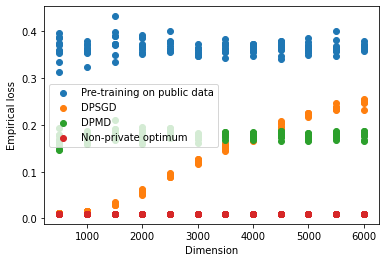

Running on dimension 4500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

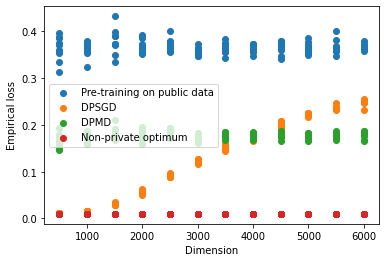

Running on dimension 5000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

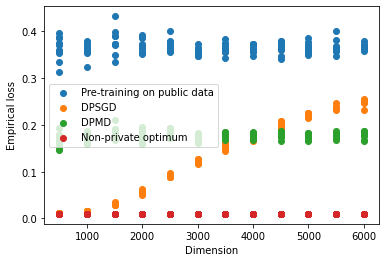

Running on dimension 5500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

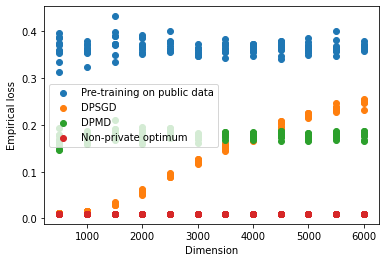

Running on dimension 6000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

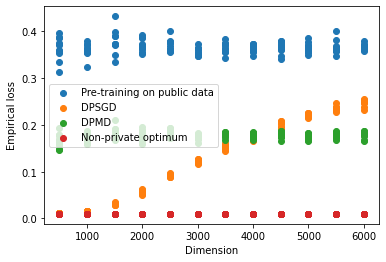

Running on dimension 500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 

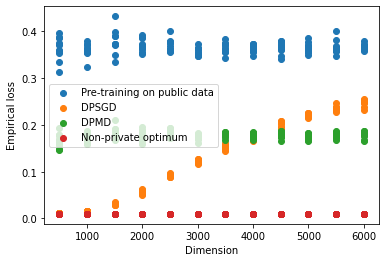

Running on dimension 1000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

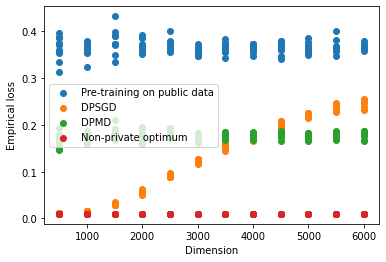

Running on dimension 1500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

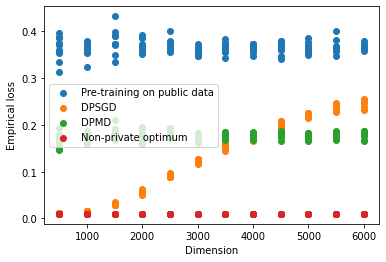

Running on dimension 2000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

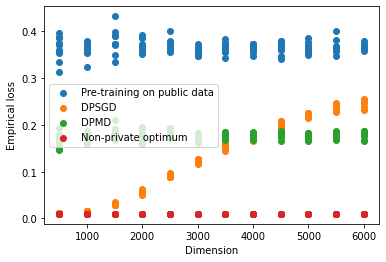

Running on dimension 2500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

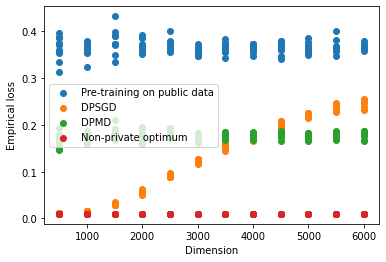

Running on dimension 3000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

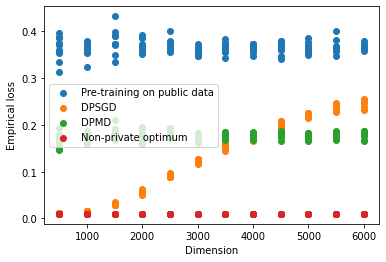

Running on dimension 3500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

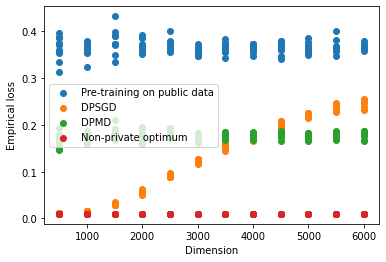

Running on dimension 4000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

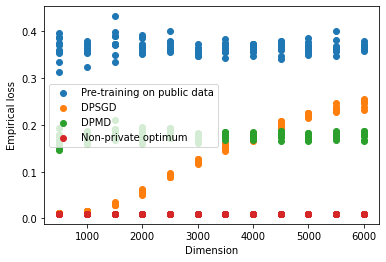

Running on dimension 4500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

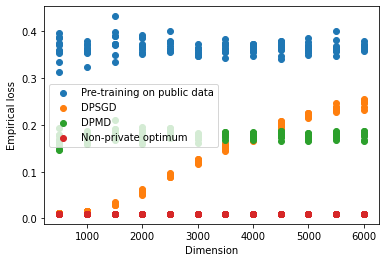

Running on dimension 5000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

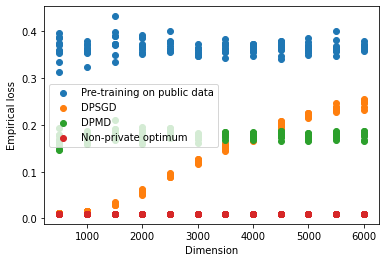

Running on dimension 5500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

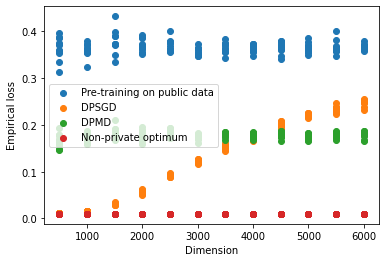

Running on dimension 6000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

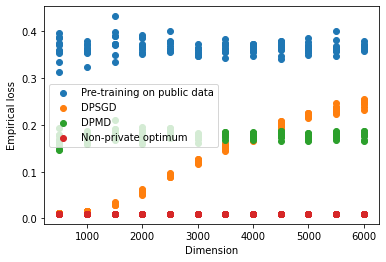

Running on dimension 500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 

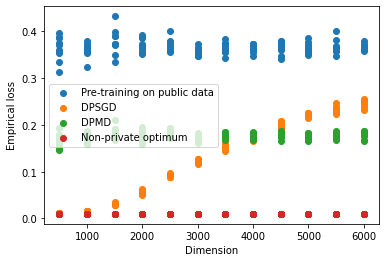

Running on dimension 1000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

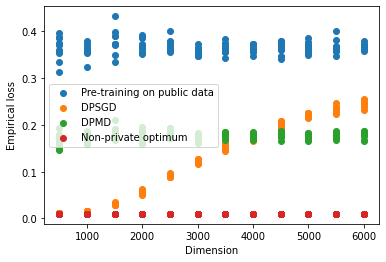

Running on dimension 1500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

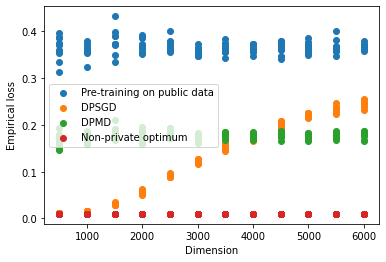

Running on dimension 2000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

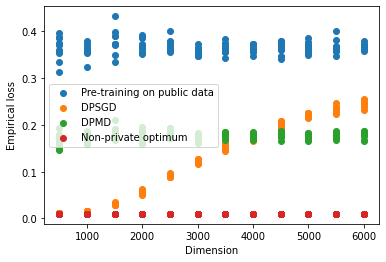

Running on dimension 2500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

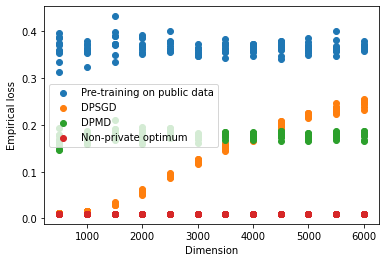

Running on dimension 3000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

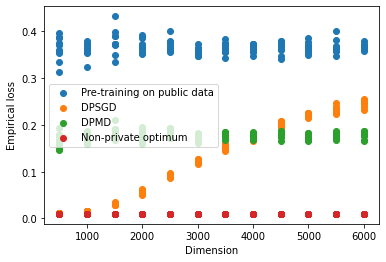

Running on dimension 3500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

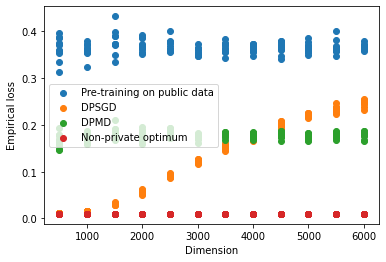

Running on dimension 4000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

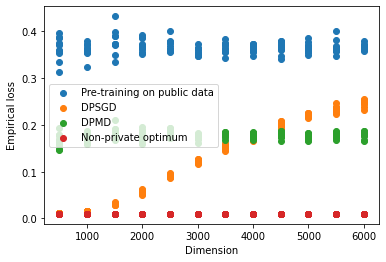

Running on dimension 4500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

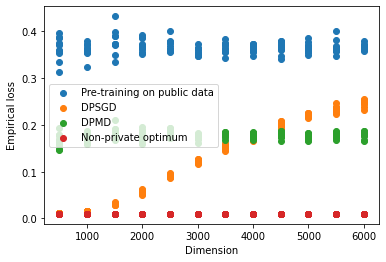

Running on dimension 5000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

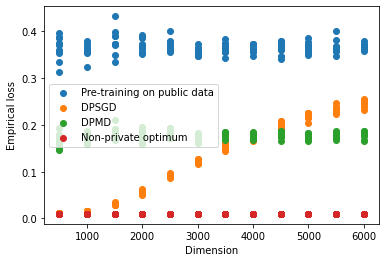

Running on dimension 5500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

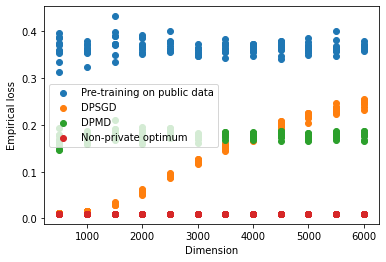

Running on dimension 6000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

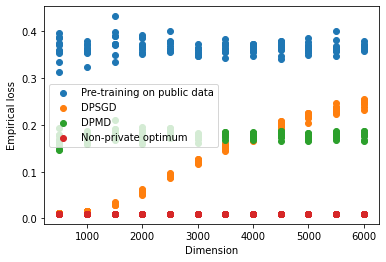

Running on dimension 500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 

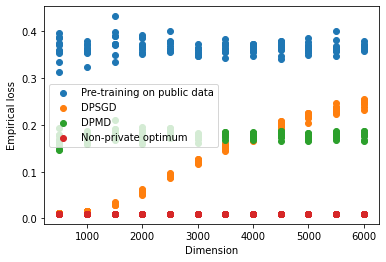

Running on dimension 1000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

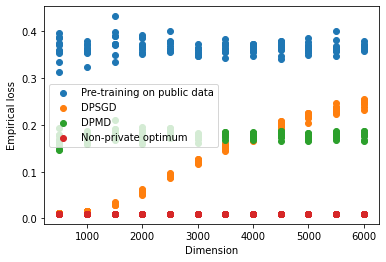

Running on dimension 1500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

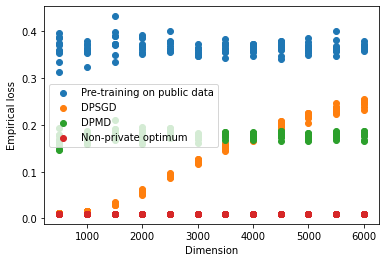

Running on dimension 2000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

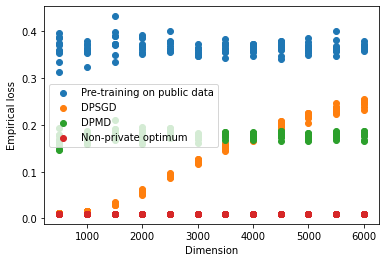

Running on dimension 2500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

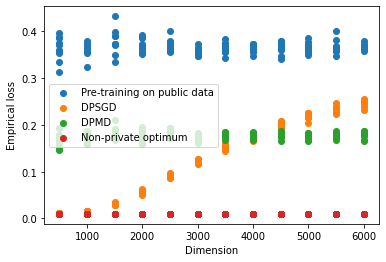

Running on dimension 3000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

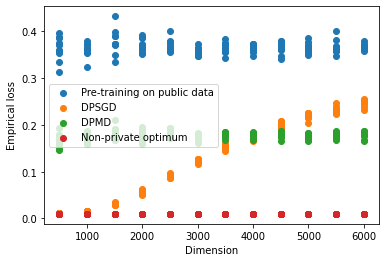

Running on dimension 3500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

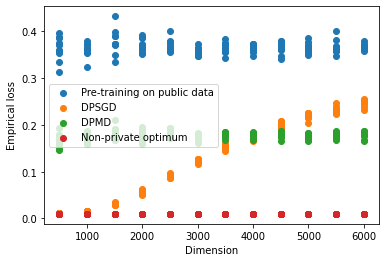

Running on dimension 4000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

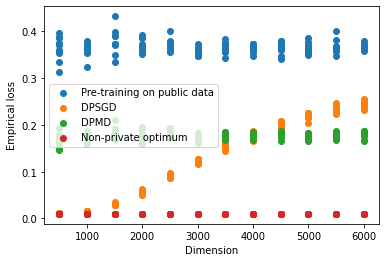

Running on dimension 4500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

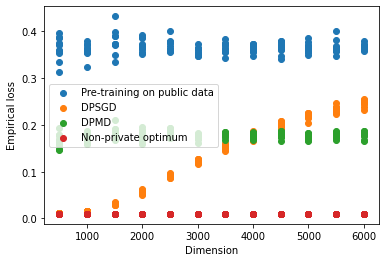

Running on dimension 5000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

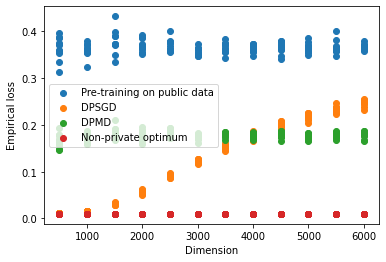

Running on dimension 5500
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

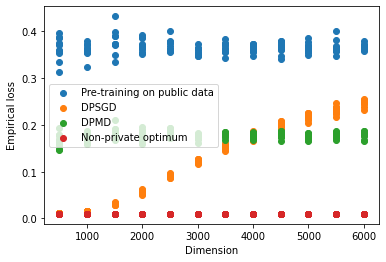

Running on dimension 6000
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate: 0.16, Clipping norm: 1.0
Learning rate: 0.16, Clipping norm: 2.0
Learning rate: 0.16, Clipping norm: 3.0
Learning rate: 0.01, Clipping norm: 1.0
Learning rate: 0.01, Clipping norm: 2.0
Learning rate: 0.01, Clipping norm: 3.0
Learning rate: 0.04, Clipping norm: 1.0
Learning rate: 0.04, Clipping norm: 2.0
Learning rate: 0.04, Clipping norm: 3.0
Learning rate:

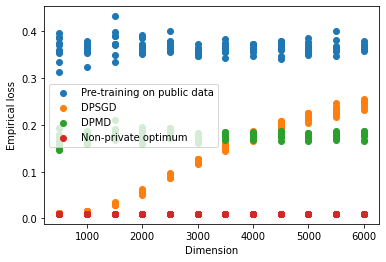

In [46]:
# pubresults = []
# sgdresults = []
# mixedresults = []
# mdresults = []
# npresults = []

#Synthetic dataset generation

for sample in range(9):
    for dim in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]:
        print("Running on dimension "+str(dim))
        ysd = 0.1
        privatesamples = 20000
        publicsamples = dim*2
        testsamples = 5000
        targeteps = 1.0
        batch_size = 1000

        weight = np.random.normal(size = dim, scale = 1.0/np.sqrt(dim))
        bias = 0.0

        def gen_loader(samples, bs, save):
            x = [np.random.normal(scale = 1.0, size = dim) for i in range(samples)]
            preds = [np.dot(weight, samp)+bias for samp in x]
            #print(np.mean(np.abs(preds)))
            y = [pred+np.random.normal(scale = ysd, size = 1) for pred in preds]
            opt = np.mean([(preds[i] - y[i])**2 for i in range(samples)])
            #if save:
            #    npresults.append([dim, opt])
            dataset = TensorDataset(torch.Tensor(x),torch.Tensor(y)) 
            return x, y, DataLoader(dataset, batch_size = bs, shuffle = True), opt 

        pubx, puby, publicfullloader, publicopt = gen_loader(publicsamples, publicsamples, False)
        privx, privy, privateloader, privateopt = gen_loader(privatesamples, batch_size, True)
        _, _, testloader, testopt = gen_loader(testsamples, batch_size, False)
        mixedx = pubx + privx
        mixedy = puby + privy
        mixedloader = DataLoader(TensorDataset(torch.Tensor(mixedx), torch.Tensor(mixedy)), 
                                 batch_size = batch_size, shuffle = True)

        pubmat = np.transpose(np.array(pubx)).dot(np.array(pubx))/publicsamples
        w, v = np.linalg.eig(pubmat)
        maxeig = max(w)
        pubmat = pubmat/maxeig


    #     #Logistic regression network
    #     class Net(torch.nn.Module):
    #          def __init__(self):
    #             super(Net, self).__init__()
    #             self.linear = torch.nn.Linear(dim, 1, bias=False)

    #          def forward(self, x):
    #             y = self.linear(x)
    #             return y

    #     def lrnet():
    #         return Net()





        #Parameters for pre-training on public data
        publicepochs = 100
        publiceta = 0.005
        #Parameters for mirror descent
        privateepochs = 40
        privatesubepochs = 5
        #privateeta = 0.025 #The multiplier in the mirror descent step; what eta would be if the public loss was l_2^2
        #gradienteta = 1.0/privatesubepochs #The eta used in gradient descent to approximately apply the mirror descent step
        alpha = 0.0 #Multiplier for regularizer of public loss
        #max_grad_norm = 1.0
        criterion = nn.MSELoss()
        PATH = "./mirrorLinReg.pt"




        model = lrnet()
        model = model.to(device)
        publicoptimizer = optim.SGD(model.parameters(), lr = publiceta)

        #print("Random model:")
        test(model, publicfullloader, privateloader, device, False)

        #Pre-train with public data
        for epoch in range(publicepochs):
            model.train()
            for i, data in enumerate(publicfullloader, 0):
                model.zero_grad()
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
        #         reg = 0.0
        #         for param in model.parameters():
        #             reg += 0.5 * (param ** 2).sum()
                loss = criterion(outputs, labels) #+ alpha * reg / 2.0
                loss.backward()
                publicoptimizer.step()
        torch.save(model.state_dict(), PATH)
        trainloss = test(model, privateloader, testloader, device, False)
        #pubresults.append([dim, trainloss])

    #     #print("Initial model:")
    #     #test(model, publicfullloader, privateloader, device, False)




        #Benchmark: SGD on private data (from warm start / with public-based clipping)

        epochs = 40
        #model = Net()
        globalminloss = 999999
        bestparams = (None, None)
        for trial in range(5):
            for lr in [.01, .04, .16]:
                for max_grad_norm in [1.0, 2.0, 3.0]:
                    model = lrnet()
                    model.load_state_dict(torch.load(PATH))
                    model = model.to(device)
                    optimizer = optim.SGD(model.parameters(), lr = lr)
                    accountant = PrivacyEngine(model, sample_rate = 1.0*batch_size/privatesamples, epochs = epochs,
                                               max_grad_norm = max_grad_norm, target_epsilon = targeteps, target_delta = .00001)
                    accountant.attach(optimizer)

                #     print("Initial model:")
                #     test(model, privateloader, testloader, device)
                    minloss = 999999.0

                    for epoch in range(epochs):
                        model.train()
                        for i, data in enumerate(privateloader, 0):
                    #         if i == 0:
                    #             for ipub, datapub in enumerate(publicfullloader, 0):
                    #                 model.zero_grad()
                    #                 images, labels = datapub[0].to(device), datapub[1].to(device)
                    #                 outputs = model(images)
                    #                 loss = criterion(outputs, labels)
                    #                 loss.backward()
                    #                 #oldpubgrad = [param.grad.clone() for param in list(model.parameters())]
                    #                 all_norms = calc_sample_norms(accountant.clipper._named_grad_samples(),
                    #                                               flat = not accountant.clipper.norm_clipper.is_per_layer,)
                    #                 batchmaxnorm = np.percentile(np.array(all_norms[0].tolist()), 90)
                    #                 print(batchmaxnorm)
                    #                 accountant.clipper.norm_clipper.flat_value = batchmaxnorm
                    #                 accountant.max_grad_norm = batchmaxnorm

                            model.zero_grad()
                            images, labels = data[0].to(device), data[1].to(device)
                            outputs = model(images)
                    #         reg = 0.0
                    #         for param in model.parameters():
                    #             reg += 0.5 * (param ** 2).sum()
                            loss = criterion(outputs, labels) #+ alpha * reg / 2.0
                            loss.backward()
                            optimizer.step()
                        trainloss = test(model, privateloader, testloader, device, False)
                        minloss = min(minloss, trainloss)
                    print("Learning rate: "+str(lr)+", Clipping norm: "+str(max_grad_norm))
                    #print("Epoch "+str(epoch+1))
                    eps, _ = accountant.get_privacy_spent()
                    #print("Epsilon: "+str(eps)+", Delta: "+str(accountant.target_delta))
                    test(model, privateloader, testloader, device, False)
                   # print("Loss: "+str(minloss)+", Accuracy: "+str(maxacc))
                    if minloss < globalminloss:
                        globalminloss = minloss
                        bestparams = (lr, max_grad_norm)
        #print("Best LR: "+str(bestparams[0])+", Clipping Norm: "+str(bestparams[1]))
        sgdresults.append([dim, globalminloss])

    #     #Benchmark: SGD on private+public data (from warm start / with public-based clipping)

    #     epochs = 40
    #     #model = Net()
    #     globalminloss = 999999
    #     bestparams = (None, None)
    #     for lr in [0.005, .01, .02, .04, .08, .16]:
    #         for max_grad_norm in [1.0, 2.0]:
    #             for trial in range(11):
    #                 model = lrnet()
    #                 model.load_state_dict(torch.load(PATH))
    #                 model = model.to(device)
    #                 optimizer = optim.SGD(model.parameters(), lr = lr)
    #                 accountant = PrivacyEngine(model, sample_rate = 1.0*batch_size/(privatesamples+publicsamples), epochs = epochs,
    #                                            max_grad_norm = max_grad_norm, target_epsilon = targeteps, target_delta = .00001)
    #                 accountant.attach(optimizer)

    #             #     print("Initial model:")
    #             #     test(model, privateloader, testloader, device)
    #                 minloss = 999999.0

    #                 for epoch in range(epochs):
    #                     model.train()
    #                     for i, data in enumerate(mixedloader, 0):
    #                 #         if i == 0:
    #                 #             for ipub, datapub in enumerate(publicfullloader, 0):
    #                 #                 model.zero_grad()
    #                 #                 images, labels = datapub[0].to(device), datapub[1].to(device)
    #                 #                 outputs = model(images)
    #                 #                 loss = criterion(outputs, labels)
    #                 #                 loss.backward()
    #                 #                 #oldpubgrad = [param.grad.clone() for param in list(model.parameters())]
    #                 #                 all_norms = calc_sample_norms(accountant.clipper._named_grad_samples(),
    #                 #                                               flat = not accountant.clipper.norm_clipper.is_per_layer,)
    #                 #                 batchmaxnorm = np.percentile(np.array(all_norms[0].tolist()), 90)
    #                 #                 print(batchmaxnorm)
    #                 #                 accountant.clipper.norm_clipper.flat_value = batchmaxnorm
    #                 #                 accountant.max_grad_norm = batchmaxnorm

    #                         model.zero_grad()
    #                         images, labels = data[0].to(device), data[1].to(device)
    #                         outputs = model(images)
    #                 #         reg = 0.0
    #                 #         for param in model.parameters():
    #                 #             reg += 0.5 * (param ** 2).sum()
    #                         loss = criterion(outputs, labels) #+ alpha * reg / 2.0
    #                         loss.backward()
    #                         optimizer.step()
    #                     trainloss = test(model, privateloader, testloader, device, False)
    #                     minloss = min(minloss, trainloss)
    #                 print("Learning rate: "+str(lr)+", Clipping norm: "+str(max_grad_norm))
    #                 #print("Epoch "+str(epoch+1))
    #                 eps, _ = accountant.get_privacy_spent()
    #                 #print("Epsilon: "+str(eps)+", Delta: "+str(accountant.target_delta))
    #                 test(model, privateloader, testloader, device, False)
    #                # print("Loss: "+str(minloss)+", Accuracy: "+str(maxacc))
    #                 if minloss < globalminloss:
    #                     globalminloss = minloss
    #                     bestparams = (lr, max_grad_norm)
    #     #print("Best LR: "+str(bestparams[0])+", Clipping Norm: "+str(bestparams[1]))
    #     mixedresults.append([dim, globalminloss])



#         globalminloss = 999999.0
#         bestparams = (None, None)
#         for alpha in [.02, .04, .08, .16, .32]:
#             pubmatinv = torch.from_numpy(np.linalg.inv(pubmat+alpha*np.identity(dim)/2)).to(device)
#             pubmatinv = pubmatinv.type(torch.FloatTensor).to(device)
#             for lr in [.01, .04, .16]:
#                 for max_grad_norm in [1.0, 2.0, 3.0]:
#                         minloss = 999999
#                         model = lrnet()
#                         model.load_state_dict(torch.load(PATH)) #Toggle this to load warm start
#                         model = model.to(device)

#                         privateoptimizer = optim.SGD(model.parameters(), lr = 0)
#                         accountant = PrivacyEngine(model, sample_rate = 1.0*batch_size/privatesamples, epochs = privateepochs,
#                                                     max_grad_norm = max_grad_norm, target_epsilon = targeteps, target_delta = .00001)
#                         accountant.attach(privateoptimizer)

#                         mdoptimizer = optim.SGD(model.parameters(), lr = lr)

#                         for epoch in range(privateepochs):
#                             starttime = time.time()
#                             model.train()

#                             #Store gradient of private loss in privgrad
#                             model.zero_grad()
#                             images, labels = data[0].to(device), data[1].to(device)
#                             outputs = model(images)
#                             loss = criterion(outputs, labels)
#                             loss.backward()      
#                             #Clip and add noise
#                             privateoptimizer.step()
#                             privgrad = [param.grad.clone() for param in list(model.parameters())][0].to(device)
#                             inter1 = torch.transpose(privgrad, 0, 1).to(device)
#                             pubmatinv = pubmatinv.type(torch.FloatTensor).to(device)
#                             inter2 = torch.mm(pubmatinv, inter1).to(device)
#                             privgrad = torch.transpose(inter2, 0, 1).to(device)
#                             for param in model.parameters():
#                                 param.grad = privgrad

#                             mdoptimizer.step()
#                             eps, _ = accountant.get_privacy_spent()

#                             endtime = time.time()
#                             trainloss = test(model, privateloader, testloader, device, False)
#                             minloss = min(minloss, trainloss)

#                         #print("Learning rate: "+str(lr)+", Clipping norm: "+str(max_grad_norm))
#                         #test(model, privateloader, testloader, device, False)
#                         model.train()
#                         if minloss < globalminloss:
#                             globalminloss = minloss
#                             bestparams = (lr, max_grad_norm, alpha)
#         print("Best LR: "+str(bestparams[0])+", Clipping Norm: "+str(bestparams[1])+", Alpha: "+str(bestparams[2]))
#         mdresults.append([dim, globalminloss])




        sgdresults = sorted(sgdresults)
        mixedresults = sorted(mixedresults)
        mdresults = sorted(mdresults)
        plt.clf()
        plt.scatter([x[0] for x in pubresults], [x[1] for x in pubresults], label = "Pre-training on public data")
        plt.scatter([x[0] for x in sgdresults], [x[1] for x in sgdresults], label = "DPSGD")
        #plt.scatter([x[0] for x in mixedresults], [x[1] for x in mixedresults], label = "DPSGD (private+public)")
        plt.scatter([x[0] for x in mdresults], [x[1] for x in mdresults], label = "DPMD")
        plt.scatter([x[0] for x in npresults], [x[1] for x in npresults], label = "Non-private optimum")
        plt.xlabel("Dimension")
        plt.ylabel("Empirical loss")
        plt.legend()
        plt.savefig("SyntheticLinRegResults")
        plt.show()

        results = (pubresults, sgdresults, mdresults, npresults)
        pickle.dump(results, open("LinRegResults.p", "wb"))

[[500, 0.14545014649629592], [500, 0.1493321105837822], [500, 0.1569630429148674], [500, 0.1597139097750187], [500, 0.16063945069909097], [500, 0.16661363393068312], [500, 0.16919023171067238], [500, 0.17800972163677214], [500, 0.17821130231022836], [500, 0.17824123576283454], [500, 0.19318494573235512], [1000, 0.1585768610239029], [1000, 0.1593346804380417], [1000, 0.16492370143532753], [1000, 0.16881690472364425], [1000, 0.16908453553915023], [1000, 0.17307620123028755], [1000, 0.17597022652626038], [1000, 0.1802470125257969], [1000, 0.18543250635266303], [1000, 0.18777821958065033], [1500, 0.1681481458246708], [1500, 0.17790434285998344], [1500, 0.1779846027493477], [1500, 0.17991402074694635], [1500, 0.18266814574599266], [1500, 0.18355270400643348], [1500, 0.1851210117340088], [1500, 0.1910680927336216], [1500, 0.19129250645637513], [1500, 0.21048666015267373], [2000, 0.15910334661602973], [2000, 0.1650916501879692], [2000, 0.17097297459840774], [2000, 0.178383519500494], [2000, 0

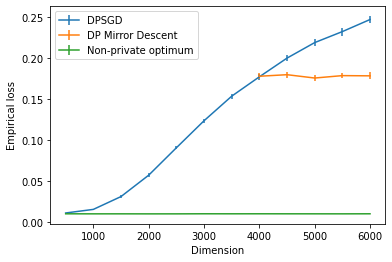

In [53]:
import math
print(mdresults)
sgdresults = sorted(sgdresults)
mixedresults = sorted(mixedresults)
tmdresults = [item for item in mdresults if item[0] >= 4000]
tmdresults = sorted(tmdresults)
print(tmdresults)
sgdbars = []
mdbars = []
npbars = []
for dim in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5500, 6000]:
    sgdr = [item[1] for item in sgdresults if item[0] == dim]
    mdr = [item[1] for item in tmdresults if item[0] == dim]
    npr = [item[1] for item in npresults if item[0] == dim]
    sgdbars.append((dim, np.mean(sgdr), 1.96*np.std(sgdr)/math.sqrt(len(sgdr))))
    npbars.append((dim, np.mean(npr), 1.96*np.std(npr)/math.sqrt(len(npr))))
    if len(mdr) > 1:
        mdbars.append((dim, np.mean(mdr), 1.96*np.std(mdr)/math.sqrt(len(mdr))))
plt.clf()
plt.errorbar([item[0] for item in sgdbars], [item[1] for item in sgdbars], yerr = [item[2] for item in sgdbars], label = "DPSGD")
plt.errorbar([item[0] for item in mdbars], [item[1] for item in mdbars], yerr = [item[2] for item in mdbars], label = "DP Mirror Descent")
plt.errorbar([item[0] for item in npbars], [item[1] for item in npbars], yerr = [item[2] for item in npbars], label = "Non-private optimum")
plt.xlabel("Dimension")
plt.ylabel("Empirical loss")
plt.legend()
plt.savefig("SyntheticLinRegResults")
plt.show()

In [44]:
npresults = npresults[:-1]